In [75]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import pandas as pd

In [76]:
df = pd.read_csv("TransportData.csv")
df

,Unnamed: 0,dem
0,1,12
1,2,13
2,3,14
3,4,15


In [77]:
dic_demand={}
for j in range(len(df)):
    dic_demand[j+1]=df.loc[j,'dem']
print(dic_demand)

{1: 12, 2: 13, 3: 14, 4: 15}


In [78]:
dic_demand={}
for j in range(1,5):
    dic_demand[j]=50*j
    
dic_distance={}
for i in range(1,4):
    for j in range(1,5):
        dic_distance[i,j]=50*(j*i)
    
print(dic_demand,dic_distance)

{1: 50, 2: 100, 3: 150, 4: 200} {(1, 1): 50, (1, 2): 100, (1, 3): 150, (1, 4): 200, (2, 1): 100, (2, 2): 200, (2, 3): 300, (2, 4): 400, (3, 1): 150, (3, 2): 300, (3, 3): 450, (3, 4): 600}


In [52]:
model = AbstractModel()
model.N=Param(mutable=True)
model.M=Param(mutable=True)

model.i = RangeSet(model.N)
model.j = RangeSet(model.M)
model.Demand =Param(model.j, mutable=True) 
model.pmin = Param(model.i)
model.pmax = Param(model.i)
model.Cost = Param(model.i, mutable=True)

model.distance = Param(model.i,model.j, mutable=True)
model.x = Var(model.i,model.j, bounds=(0,300), within=Reals)
model.OF = Var(within=Reals)

def Pbounds(model,i):
    return (model.pmin[i] , model.pmax[i])
model.P = Var(model.i, bounds=Pbounds, domain=Reals)
def rule_C1(model,i):
        return  sum(model.x[i,j] for j in model.j)==model.P[i]
model.C1   = Constraint(model.i,rule=rule_C1)

def rule_C2(model,j):
        return  sum(model.x[i,j] for i in model.i)>=model.Demand[j]
model.C2   = Constraint(model.j,rule=rule_C2)
def rule_OF(model):
    return model.OF==sum(model.P[i]*model.Cost[i] for i in model.i) + sum(model.x[i,j]*model.distance[i,j] for i in model.i for j in model.j)
model.C3   = Constraint(rule=rule_OF)
model.obj1 = Objective(expr=model.OF, sense=minimize)


In [79]:
opt = SolverFactory('glpk')
model.N=3
model.M=4

#instance = model.create_instance("Ex31.dat")
instance = model.create_instance("Ex31-incomplete.dat")

In [80]:
for j in instance.j:
    instance.Demand[j]=dic_demand[j]
    
for i in instance.i:
    for j in instance.j:
        instance.distance[i,j]=dic_distance[i,j]

In [81]:
results = opt.solve(instance) # solves and updates instance
print('OF= ',value(instance.OF))

OF=  81900.0


(0.06, 0.9400000000000001, 0.06, 0.9400000000000001)

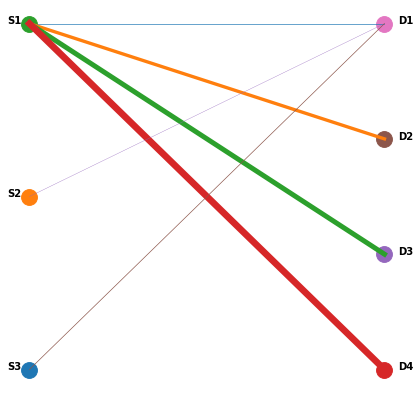

In [82]:
fig = plt.figure(figsize=(7,7))
Ni=3
Nj=4
supplyY=np.linspace(0.1,0.9,Ni)
supplyX=0.1*np.ones_like(supplyY)
demandY=np.linspace(0.1,0.9,Nj)
demandX=0.9*np.ones_like(demandY)

for i in instance.i:
    for j in instance.j:
        if value(instance.x[i,j])>0.1:
            plt.plot([supplyX[Ni-i],demandX[Nj-j]],[supplyY[Ni-i],demandY[Nj-j]],lw=value(instance.x[i,j])/30)
for c in range(0,Ni):
    plt.scatter(supplyX[c],supplyY[c],s=250)
    plt.text(supplyX[Ni-c-1]-0.05,supplyY[Ni-c-1],'S'+str(c+1),fontweight='bold')
for c in range(0,Nj):
    plt.scatter(demandX[c],demandY[c],s=250)
    plt.text(demandX[Nj-c-1]+0.03,demandY[Nj-c-1],'D'+str(c+1),fontweight='bold')
plt.axis('off')


In [83]:
for iter in range(5):
    for j in instance.j:
        instance.Demand[j]=iter*dic_demand[j]/2
    results = opt.solve(instance) # solves and updates instance
    print(iter, 'OF= ',value(instance.OF))
    
    

0 OF=  4170.0
1 OF=  42400.0
2 OF=  81900.0
3 OF=  121650.0
4 OF=  180720.0
